# Generalized Additive Model

The following is a brief illustrative example of how generalized additive models (GAMs) can be implemented in `delicatessen` by-hand. 

Paul Zivich (2023/01/02)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import delicatessen as deli
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_ridge_regression

%matplotlib inline
mpl.rcParams['figure.dpi']= 100
np.random.seed(202301)

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Matplotlib version:  ", mpl.__version__)
print("Delicatessen version:", deli.__version__)

NumPy version:        1.22.2
SciPy version:        1.9.2
Pandas version:       1.4.1
Matplotlib version:   3.5.1
Delicatessen version: 1.0


For illustrative purposes, we will simulate some data with a non-linear relationship between $Y$ and $X$. 

In [2]:
n = 2000

d = pd.DataFrame()
d['X'] = np.random.uniform(-5, 5, size=n)
d['C'] = 1
d['Y'] = np.exp(np.sin(d['X'] + 0.5)) + np.abs(d['X'])

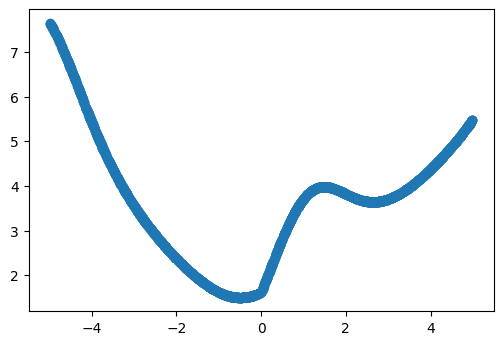

In [3]:
plt.plot(d['X'], d['Y'], 'o')

Now we will add some random Gaussian noise to $Y$ for our regression models. With the random noise, the underlying functional form will not be as easy to see.

In [4]:
d['Y'] = d['Y'] + np.random.normal(scale=1.5, size=n)

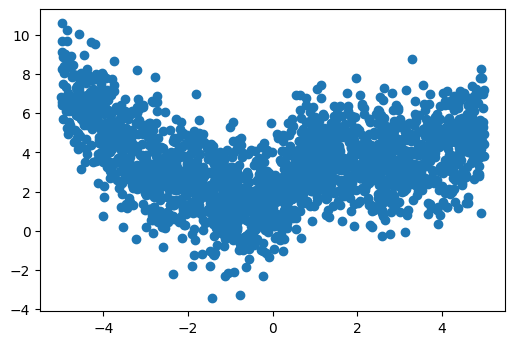

In [5]:
plt.plot(d['X'], d['Y'], 'o')

## Implementing a GAM

### Processing Data

To get our GAM working, we need to generate splines for the continuous terms. Below is a simple function to generate generic splines at pre-specified knot locations. The default `term=3` means that cubic splines are being generated.

In [6]:
def spline(variable, knots, term=3):
    # Processing input and output arrays
    x = np.asarray(variable)               # Converting input variable to another array
    V = np.empty((x.shape[0], len(knots)))   # Creating the output spline array

    # Generating each spline with it's corresponding term
    for i in range(len(knots)):
        V[:, i] = np.where(x > knots[i], (x - knots[i])**term, 0)
        V[:, i] = np.where(np.isnan(x), np.nan, V[:, i])

    # Return splines
    return V

In [7]:
knots = [-4, -2, -1, 0, 1, 2, 4]
cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

d[cols] = spline(d['X'], knots=knots, term=3)

In [8]:
y = np.asarray(d['Y'])
X = np.asarray(d[['C', 'X'] + cols])

### Penalized Regression

GAM use penalized regression. Here, we will use $L_2$ penalization for our GAM. For that, we can use the built-in estimating equations for Ridge regression in `delicatessen`. Importantly, we only want to penalized the 'wiggliness' of our model. So, we will *not* be penalizing the intercept or the linear $X$ term. In short, the penalty is only applied to the spline terms.

In [9]:
def psi(theta):
    return ee_ridge_regression(theta=theta,
                               y=y,
                               X=X,
                               model='linear',
                               penalty=[0, 0, ] + [2, ]*7)

### Estimation

Finally, we can estimate the GAM. Here, we use the Levenberg-Marquette root-finding algorithm.

In [10]:
estr = MEstimator(psi, init=[0., ]*9)
estr.estimate(solver='lm')

## Results

As the estimated parameters of a GAM can be difficult to interpret, the following is a plot of the estimated relationship from the GAM. As we will see in the plot, the GAM closely approximates the true underlying function. How well the GAM approximates the true relationship will depend on the chosen knot locations and the strength of the penalty term.

In [11]:
p = pd.DataFrame()
p['X'] = np.linspace(-5, 5, 100)
p['C'] = 1
p[cols] = spline(p['X'], knots=knots, term=3)
Xp = np.asarray(p[['C', 'X'] + cols])

y_pred = np.dot(Xp, estr.theta)

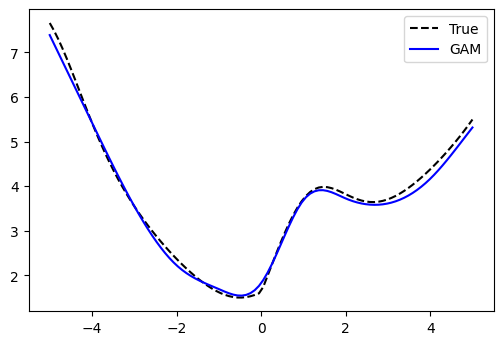

In [12]:
plt.plot(p['X'], np.exp(np.sin(p['X'] + 0.5)) + np.abs(p['X']), '--', color='k', label='True')
plt.plot(p['X'], y_pred, '-', color='blue', label='GAM')
plt.legend()

## Penalty and Wiggliness

To highlight how the penalty controls the 'wiggliness' of the model, let's repeat the previous analysis but we will increase the penalty. Rather than 2, the penalty will be 10000. This will push the model to create a smoother representation.

In [13]:
def psi(theta):
    return ee_ridge_regression(theta=theta,
                               y=y,
                               X=X,
                               model='linear',
                               penalty=[0, 0, ] + [10000, ]*7)

In [14]:
estr = MEstimator(psi, init=[0., ]*9)
estr.estimate(solver='lm')

In [15]:
p = pd.DataFrame()
p['X'] = np.linspace(-5, 5, 100)
p['C'] = 1
p[cols] = spline(p['X'], knots=knots, term=3)
Xp = np.asarray(p[['C', 'X'] + cols])

y_pred = np.dot(Xp, estr.theta)

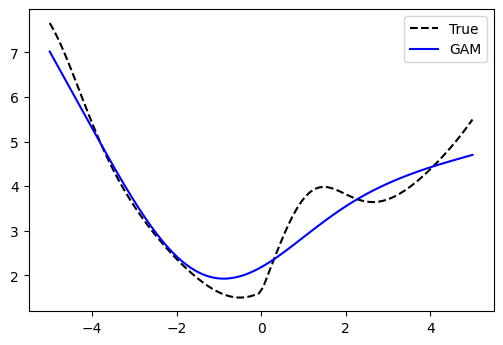

In [16]:
plt.plot(p['X'], np.exp(np.sin(p['X'] + 0.5)) + np.abs(p['X']), '--', color='k', label='True')
plt.plot(p['X'], y_pred, '-', color='blue', label='GAM')
plt.legend()

As seen here, the larger penalty reduces the complexity of our model and favors a simpler representation. In this case, the penalty is too strong to capture the underlying function (the true model is more wiggly). 

Here, we can see a general trend. Namely, a linear relationship is favored as the penalty increases. In general, it is known that as the penalty goes to infinity, the GAM will approach a GLM. We can also demonstrate this by making a very large penalty, which we do in the following.

In [17]:
def psi(theta):
    return ee_ridge_regression(theta=theta,
                               y=y,
                               X=X,
                               model='linear',
                               penalty=[0, 0, ] + [1e10, ]*7)

In [18]:
estr = MEstimator(psi, init=[0., ]*9)
estr.estimate(solver='lm')

In [19]:
p = pd.DataFrame()
p['X'] = np.linspace(-5, 5, 100)
p['C'] = 1
p[cols] = spline(p['X'], knots=knots, term=3)
Xp = np.asarray(p[['C', 'X'] + cols])

y_pred = np.dot(Xp, estr.theta)

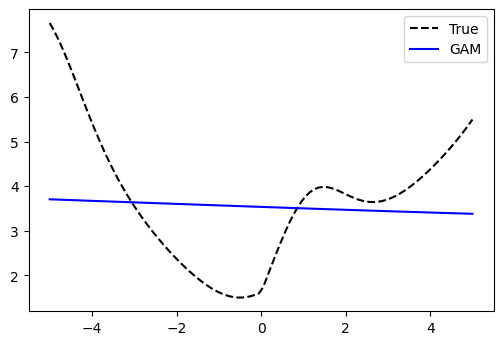

In [20]:
plt.plot(p['X'], np.exp(np.sin(p['X'] + 0.5)) + np.abs(p['X']), '--', color='k', label='True')
plt.plot(p['X'], y_pred, '-', color='blue', label='GAM')
plt.legend()

Effectively, the penalty for the spline terms is so large that all the parameters corresponding to the spline terms are forced to be nearly zero. As a result, only the intercept and linear term for $X$ have the potential to be non-zero.

To summarize these results regarding the penalty strength, there is a balance between the smoothness and wiggliness of our model. These differences depend on the sample size and the underlying data generating process.

## Conclusions

GAMs are a flexible method that place fewer constraints on the functional forms of relationships via splines. These splines don't require us to know the true underlying functional form. Instead, the higher-order splines (with well-chosen knots and penalization) can serve as close approximations. To implement GAMs, `delicatessen` can easily be used with a little pre-processing of the input data.